In [3]:
import re
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import seaborn as sns

In [4]:
df = pd.read_csv('clean-data/Whiskey_data/Whiskey_Advocate_All_scraped_KHupdate-23 Jul (Team Style Defined) with descriptions.csv')

In [5]:
df.columns

Index(['Unnamed: 0', 'Index', 'Maker', 'Year Distrilled', 'age in cast', 'ABV',
       'Single Malt Scotch', 'Flavored Whiskey and Liqueurs', 'Bourbon',
       ' Blended Malt Scotch Whisky ', 'Blended Scotch Whisky',
       'Blended Whiskey (Multi-country)',
       ' Single Malt Whisky (Multi-country)',
       ' Single Grain Whisky (Multi-country)', 'Japan', ' Canada', 'Irish',
       'Generic Whisky (Multi-country)', 'Rye Whisky', 'White Whisky',
       'Craft Whisky', 'SUM', 'Review Score (Points)', ' price ',
       'Original Style', 'country', 'descriptions'],
      dtype='object')

In [6]:
df = df[['Single Malt Scotch', 'Flavored Whiskey and Liqueurs', 'Bourbon',
       ' Blended Malt Scotch Whisky ', 'Blended Scotch Whisky',
       'Blended Whiskey (Multi-country)',
       ' Single Malt Whisky (Multi-country)',
       ' Single Grain Whisky (Multi-country)', 'Japan', ' Canada', 'Irish',
       'Generic Whisky (Multi-country)', 'Rye Whisky', 'White Whisky','Craft Whisky', 'descriptions']]

In [7]:
#Thank you to this article for this funciton https://towardsdatascience.com/multi-class-text-classification-with-lstm-1590bee1bd17

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text
    

In [8]:
df['descriptions'] = df['descriptions'].apply(clean_text)

In [9]:
categories = list(df.columns)
categories.pop(-1)
categories

['Single Malt Scotch',
 'Flavored Whiskey and Liqueurs',
 'Bourbon',
 ' Blended Malt Scotch Whisky ',
 'Blended Scotch Whisky',
 'Blended Whiskey (Multi-country)',
 ' Single Malt Whisky (Multi-country)',
 ' Single Grain Whisky (Multi-country)',
 'Japan',
 ' Canada',
 'Irish',
 'Generic Whisky (Multi-country)',
 'Rye Whisky',
 'White Whisky',
 'Craft Whisky']

In [110]:
y = df[categories]
X = df['descriptions']

In [111]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42, test_size=0.33, shuffle=True)

print(X_train.shape)
print(X_test.shape)

(3166,)
(1560,)


<h1>Visualizing the Data</h1>

In [61]:
len(df.loc[df['Irish'] == True])

111

In [62]:
counts = []

for category in categories:
    counts.append(len(df.loc[df[category] == True]))

In [66]:
categories

['Single Malt Scotch',
 'Flavored Whiskey and Liqueurs',
 'Bourbon',
 ' Blended Malt Scotch Whisky ',
 'Blended Scotch Whisky',
 'Blended Whiskey (Multi-country)',
 ' Single Malt Whisky (Multi-country)',
 ' Single Grain Whisky (Multi-country)',
 'Japan',
 ' Canada',
 'Irish',
 'Generic Whisky (Multi-country)',
 'Rye Whisky',
 'White Whisky',
 'Craft Whisky']

<BarContainer object of 15 artists>

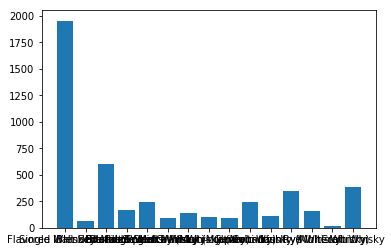

In [72]:
x = categories
y = counts

plt.bar(x, y)

<h3>Found that 'Single Malt Scotch' has a much larger representation in the dataset than the others and i am going to attempt to reduce it to see if it has a clear impact on the accuracy of the models</h3>

In [51]:
df_copy = df.copy()
df_copy.columns

Index(['Single Malt Scotch', 'Flavored Whiskey and Liqueurs', 'Bourbon',
       ' Blended Malt Scotch Whisky ', 'Blended Scotch Whisky',
       'Blended Whiskey (Multi-country)',
       ' Single Malt Whisky (Multi-country)',
       ' Single Grain Whisky (Multi-country)', 'Japan', ' Canada', 'Irish',
       'Generic Whisky (Multi-country)', 'Rye Whisky', 'White Whisky',
       'Craft Whisky', 'descriptions'],
      dtype='object')

In [52]:
df_less_scotch = df_copy.loc[df_copy['Single Malt Scotch'] == True]
len(df_less_scotch)

1954

In [53]:
df_less_scotch = df_less_scotch.sample(300)
len(df_less_scotch)

300

In [54]:
df_all_but_scotch = df_copy.loc[df_copy['Single Malt Scotch'] == False]

In [55]:
df_new_scotch = pd.concat([df_less_scotch, df_all_but_scotch])
len(df_new_scotch)

3072

In [56]:
X = df_new_scotch['descriptions']
y = df_new_scotch[categories]
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42, test_size=0.33, shuffle=True)

In [96]:
NB_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(MultinomialNB(
                    fit_prior=True, class_prior=None))),
            ])

In [107]:
result_df = pd.DataFrame(columns = ['style', 'score'], index = [i for i in range(len(categories))])
i = 0
predictions = []
for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    NB_pipeline.fit(X_train, y_train[category])
    # compute the testing accuracy
    prediction = NB_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(y_test[category], prediction)))
    result_df.iat[i, 0] = category
    result_df.iat[i, 1] = accuracy_score(y_test[category], prediction)
    predictions.append(prediction)
    i += 1

... Processing Single Malt Scotch
Test accuracy is 0.7738607050730868
... Processing Flavored Whiskey and Liqueurs
Test accuracy is 0.9871023215821152
... Processing Bourbon
Test accuracy is 0.8392089423903697
... Processing  Blended Malt Scotch Whisky 
Test accuracy is 0.9509888220120378
... Processing Blended Scotch Whisky
Test accuracy is 0.9251934651762683
... Processing Blended Whiskey (Multi-country)
Test accuracy is 0.9750644883920895
... Processing  Single Malt Whisky (Multi-country)
Test accuracy is 0.9638865004299226
... Processing  Single Grain Whisky (Multi-country)
Test accuracy is 0.9733447979363714
... Processing Japan
Test accuracy is 0.9733447979363714
... Processing  Canada
Test accuracy is 0.9312123817712812
... Processing Irish
Test accuracy is 0.9690455717970765
... Processing Generic Whisky (Multi-country)
Test accuracy is 0.9062768701633706
... Processing Rye Whisky
Test accuracy is 0.9613069647463457
... Processing White Whisky
Test accuracy is 0.997420464316423

<h4> Checking if all of the predictions are just zeroes</h4>

In [157]:
df_results = pd.DataFrame(columns = ['X_test','y_test','predictions'])
df_results['X_test'] = X_test
df_results['y_test'] = y_test['Single Malt Scotch']
df_results['predictions'] = predictions[0]

In [161]:
df_results['predictions'].value_counts()

0    1161
1       2
Name: predictions, dtype: int64

<h1>One Vs Rest Classifier with Multinominal NB</h1>

In [164]:
NB_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(MultinomialNB(
                    fit_prior=True, class_prior=None))),
            ])

In [168]:
result_df = pd.DataFrame(columns = ['style', 'score'], index = [i for i in range(len(categories))])
predictions = []
i = 0
for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    NB_pipeline.fit(X_train, y_train[category])
    # compute the testing accuracy
    prediction = NB_pipeline.predict(X_test)
    predictions.append(prediction)
    print('Test accuracy is {}'.format(accuracy_score(y_test[category], prediction)))
    result_df.iat[i, 0] = category
    result_df.iat[i, 1] = accuracy_score(y_test[category], prediction)
    i += 1

... Processing Single Malt Scotch
Test accuracy is 0.8685897435897436
... Processing Flavored Whiskey and Liqueurs
Test accuracy is 0.9852564102564103
... Processing Bourbon
Test accuracy is 0.875
... Processing  Blended Malt Scotch Whisky 
Test accuracy is 0.9653846153846154
... Processing Blended Scotch Whisky
Test accuracy is 0.948076923076923
... Processing Blended Whiskey (Multi-country)
Test accuracy is 0.9762820512820513
... Processing  Single Malt Whisky (Multi-country)
Test accuracy is 0.9673076923076923
... Processing  Single Grain Whisky (Multi-country)
Test accuracy is 0.9839743589743589
... Processing Japan
Test accuracy is 0.9794871794871794
... Processing  Canada
Test accuracy is 0.9576923076923077
... Processing Irish
Test accuracy is 0.9801282051282051
... Processing Generic Whisky (Multi-country)
Test accuracy is 0.9346153846153846
... Processing Rye Whisky
Test accuracy is 0.9717948717948718
... Processing White Whisky
Test accuracy is 0.9980769230769231
... Processi

In [177]:
df_results = pd.DataFrame(columns = ['X_test','y_test','predictions'])
df_results['X_test'] = X_test
df_results['y_test'] = y_test[' Blended Malt Scotch Whisky ']
df_results['predictions'] = predictions[3]

In [178]:
df_results['predictions'].value_counts()

0    1560
Name: predictions, dtype: int64

In [78]:
result_df

,style,score
0,Single Malt Scotch,0.86859
1,Flavored Whiskey and Liqueurs,0.985256
2,Bourbon,0.875
3,Blended Malt Scotch Whisky,0.965385
4,Blended Scotch Whisky,0.948077
5,Blended Whiskey (Multi-country),0.976282
6,Single Malt Whisky (Multi-country),0.967308
7,Single Grain Whisky (Multi-country),0.983974
8,Japan,0.979487
9,Canada,0.957692


<h1>Keras Classification Neural Network </h1>

In [2]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Embedding
from keras.layers import SpatialDropout1D
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

Using TensorFlow backend.
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [35]:
df['descriptions'][0]

'magnificently powerful intense caramels dried peats elegant cigar smoke seeds scraped vanilla beans brand new pencils peppercorn coriander seeds star anise make deeply satisfying nosing experience silky caramels bountiful fruits ripe peach stewed apple orange pith pervasive smoke elements burnt tobacco abiding finish smoke dry spices banoffee pie sweetness close perfection editors choice'

In [36]:
vectorizer = CountVectorizer(stop_words=stop_words, max_features = 100)

In [37]:
vectorizer.fit(df['descriptions'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=100, min_df=1,
        ngram_range=(1, 1), preprocessor=None,
        stop_words={'very', 't', 'over', 'his', 'how', 'by', 'the', 'again', "should've", 're', 'ma', 'your', 's', 'their', "mustn't", 'because', 'yourselves', 'our', 'couldn', 'of', 'having', 'ours', 'from', 'did', 'had', 'below', 'under', 'own', 'shan', 'some', 'so', 'if', 'through', 'don', 'was', 'been',...hy', "you'd", 'mightn', 'few', 'ain', 'them', 'there', 'each', 'yours', 'whom', 'll', 'this', 'and'},
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [38]:
X = vectorizer.transform(df['descriptions'])

In [39]:
X.shape

(4726, 100)

In [112]:
vectorizer = TfidfVectorizer(stop_words=stop_words, max_features=500, ngram_range=(1, 3))
vectorizer.fit(df['descriptions'])
X = vectorizer.transform(df['descriptions'])

In [113]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.30, random_state = 42)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(3308, 500) (3308, 15)
(1418, 500) (1418, 15)


In [114]:
model = Sequential()
# model.add(Embedding(500, 100, input_length=X.shape[1]))
# model.add(LSTM(100, return_sequences= True))
# model.add(LSTM(100))
model.add(Dense(500, input_dim = 500))
# model.add(SpatialDropout1D(0.2))
model.add(Dense(15, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 10
batch_size = 128
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 500)               250500    
_________________________________________________________________
dense_20 (Dense)             (None, 15)                7515      
Total params: 258,015
Trainable params: 258,015
Non-trainable params: 0
_________________________________________________________________


In [115]:
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.4,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)], 
                    verbose = 1)#, validation_data=(X_test, y_test))

Train on 1984 samples, validate on 1324 samples
Epoch 1/10
1984/1984 [==============================] - 1s 626us/step - loss: 2.3799 - acc: 0.3609 - val_loss: 1.9888 - val_acc: 0.4079
Epoch 2/10
1984/1984 [==============================] - 0s 64us/step - loss: 1.8810 - acc: 0.4047 - val_loss: 1.7701 - val_acc: 0.4366
Epoch 3/10
1984/1984 [==============================] - 0s 58us/step - loss: 1.6600 - acc: 0.5076 - val_loss: 1.6015 - val_acc: 0.5408
Epoch 4/10
1984/1984 [==============================] - 0s 58us/step - loss: 1.4643 - acc: 0.5731 - val_loss: 1.4603 - val_acc: 0.5740
Epoch 5/10
1984/1984 [==============================] - 0s 56us/step - loss: 1.2940 - acc: 0.6164 - val_loss: 1.3508 - val_acc: 0.6057
Epoch 6/10
1984/1984 [==============================] - 0s 56us/step - loss: 1.1505 - acc: 0.6578 - val_loss: 1.2680 - val_acc: 0.6224
Epoch 7/10
1984/1984 [==============================] - 0s 56us/step - loss: 1.0281 - acc: 0.6930 - val_loss: 1.2084 - val_acc: 0.6397
Epoch 

In [116]:
accr = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

1418/1418 [==============================] - 0s 59us/step
Test set
  Loss: 1.098
  Accuracy: 0.673


In [117]:
accr = model.evaluate(X,y)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

4726/4726 [==============================] - 0s 41us/step
Test set
  Loss: 0.939
  Accuracy: 0.725


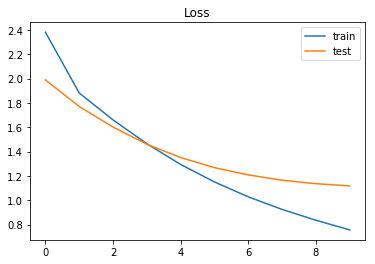

In [118]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

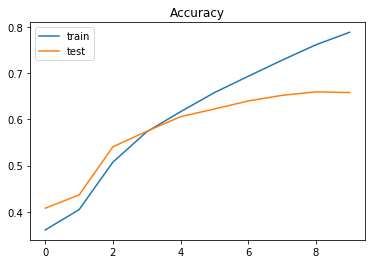

In [119]:
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show();

In [131]:
model.predict(X)

array([[5.5189780e-03, 6.4432169e-03, 1.4232084e-02, ..., 4.6066786e-03,
        5.6629819e-03, 9.2976661e-03],
       [8.4256625e-01, 1.1353976e-03, 3.5400346e-02, ..., 7.4204430e-03,
        3.6597939e-04, 6.4182156e-03],
       [2.6546299e-01, 5.2418066e-03, 2.3545597e-03, ..., 2.4265852e-03,
        3.8507592e-03, 1.3131023e-02],
       ...,
       [1.0128297e-04, 8.4531806e-02, 3.9162565e-02, ..., 3.3014540e-02,
        2.6152864e-02, 7.0181561e-01],
       [2.4300538e-02, 2.9589444e-02, 4.1269410e-02, ..., 7.5692974e-02,
        2.6047001e-02, 6.6582449e-02],
       [4.7539640e-03, 6.7689680e-02, 4.4876050e-02, ..., 1.6644315e-01,
        3.0317433e-02, 2.9821131e-01]], dtype=float32)

In [130]:
y.values[0]

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)